### Imports & installation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
pip uninstall holidays -y

Found existing installation: holidays 0.23
Uninstalling holidays-0.23:
  Successfully uninstalled holidays-0.23
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install holidays==0.23

  Using cached holidays-0.23-py3-none-any.whl (485 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [5]:
from prophet import Prophet

### Loading & transforming the data

In [6]:
train_data = pd.read_csv('burglary_train.csv')
test_data = pd.read_csv('burglary_test.csv')

In [7]:
def to_datetime(df):
    # Changes date to datetime 
    for index, value in enumerate(df['Month']):
        df.at[index, 'Month'] = datetime.strptime(value, '%Y-%m')
    return df

def get_most_frequent_locations(df):
    # Returns a list of most frequent location per month 
    df_grouped = df.groupby([pd.Grouper(key='Month', freq='M'), 'LSOA code']).size()
    most_frequent_location = df_grouped.groupby(level=0).idxmax()
    locs = []
    for loc in range(len(most_frequent_location)):
        locs.append(most_frequent_location[loc][1])
    return locs

def count_per_month(df):
    # Return a dataframe with crimes count per month
    df_per_month = df.groupby(pd.Grouper(key='Month', freq='M')).size()
    df_per_month = pd.DataFrame(df_per_month)
    df_per_month['ds'] = df_per_month.index
    df_per_month = df_per_month.rename(columns={0: 'y'})
    return df_per_month 

def add_locs(df, locs):
    # Adds most frequent location column to the dataframe
    df['loc'] = locs
    return df

In [8]:
def loc_encoding(df):
    # Returns a dataframe with encoded locations
    one_hot_encoded = pd.get_dummies(df['loc'])
    df_encoded = pd.concat([df, one_hot_encoded], axis=1)
    df_encoded = df_encoded.drop('loc', axis=1)
    return df_encoded

def get_cols_for_pred(df):
    # Returns a list of additional columns for regression 
    columns = df.iloc[:, 2:]
    return columns

In [9]:
train_data = to_datetime(train_data)
locs = get_most_frequent_locations(train_data)
train_data = count_per_month(train_data)
train_data = add_locs(train_data, locs)
train_data = loc_encoding(train_data)
pred_cols = get_cols_for_pred(train_data)

In [42]:
test_data = to_datetime(test_data)
locs = get_most_frequent_locations(test_data)
test_data = count_per_month(test_data)
test_data = add_locs(test_data, locs)
test_data = loc_encoding(test_data)

KeyError: 'Month'

## Prophet

In [11]:
prophet_model = Prophet(yearly_seasonality=True)

prophet_model.fit(train_data)

future = prophet_model.make_future_dataframe(periods=12, freq='M')
predictions = prophet_model.predict(future)

12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:23 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\nurvo\AppData\Local\Temp\ipykernel_19576\738522883.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


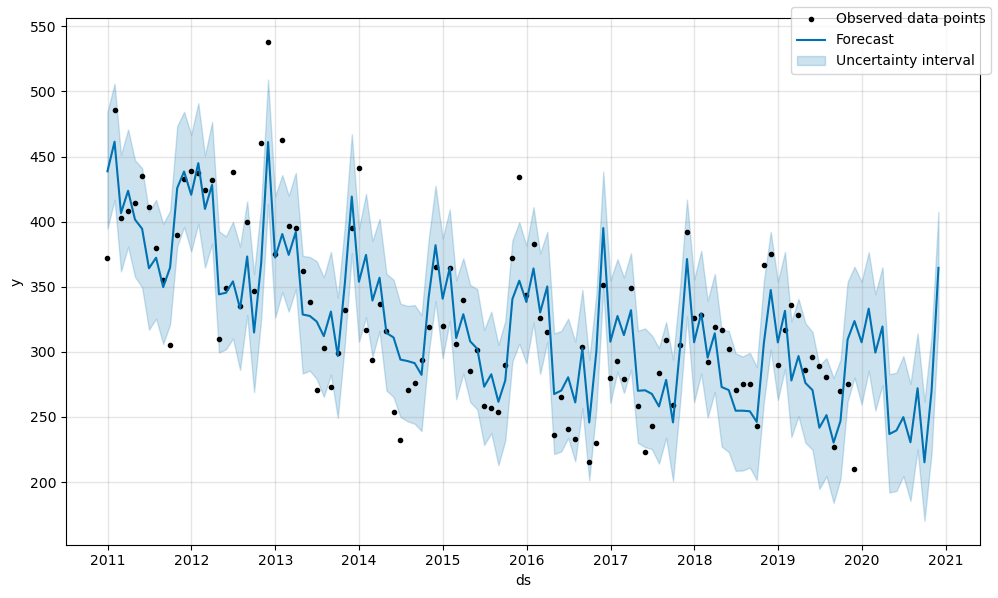

In [12]:
plt = prophet_model.plot(predictions)
plt.legend()
plt.show()

In [13]:
test_predictions = predictions[-12:]
test_predictions_reset = test_predictions.reset_index(drop=True)
test_data_reset = test_data[-12:].reset_index(drop=True)

In [15]:
mse = ((test_predictions_reset['yhat'] - test_data_reset['y']) ** 2).mean()
rmse = mse ** 0.5
print('RMSE: {:.2f}'.format(rmse))

RMSE: 87.62


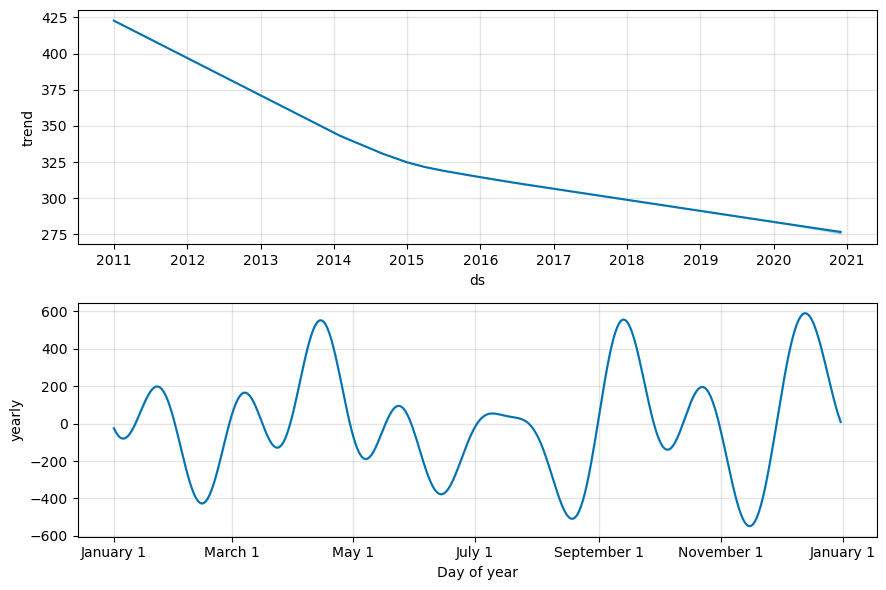

In [16]:
components = prophet_model.plot_components(predictions)

In [43]:
# def get_encoded():
#     # Retrieve the encoded values for 'encoded_cat_var1' based on the future data points
#     # For example, assuming 'ds' is the timestamp in the future timeline
#     return train_data.loc[train_data['ds'].isin(future['ds']), str(col)]

In [17]:
# prophet_model = Prophet()

# for col in pred_cols:
#     prophet_model.add_regressor(col)
# # prophet_model.fit(train_data)

# # future = prophet_model.make_future_dataframe(periods=12, freq='M')
# # regressor_data_future = get_encoded()  # Retrieve encoded regressor values for the future timeline

# # for col in pred_cols:
# #     future[col] = regressor_data_future[col]  # Assign the encoded regressor values to the future DataFrame

# # forecast = prophet_model.predict(future)  # Generate forecasts using the prepared future DataFrame

In [24]:
# new model with location as additional regressor (in dummy variables)
prophet_model_extra = Prophet(yearly_seasonality=True)

# adds all location dummies to the model and fits the training data
for col in pred_cols:
    prophet_model_extra.add_regressor(col)

prophet_model_extra.fit(train_data)

02:44:26 - cmdstanpy - INFO - Chain [1] start processing
02:44:26 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# extract column names. This is needed to create the future dataset
colnames = pred_cols.columns.values.tolist()

In [39]:
# create future dataframe, merge it with the columns where the date matches
future_extra = prophet_model_extra.make_future_dataframe(periods=12, freq='M')
future_extra = train_data[['ds']+colnames].merge(future_extra, how='outer', on='ds')
future_extra

,ds,E01000116,E01000118,E01000122,E01000123,E01000128,E01000129,E01000130,E01000131,E01000134,...,E01000296,E01000299,E01000305,E01000307,E01000310,E01000314,E01000315,E01000316,E01000322,E01033572
0,2010-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2020-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,2020-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
forecast = prophet_model.predict(future_extra) 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=986fb8fd-fd48-481b-91de-f6577d6c21b9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>